In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

In [2]:
from lightkurve import KeplerTargetPixelFile
from lightkurve import SimpleKeplerPRF, PRFPhotometry, SceneModel
from lightkurve.utils import KeplerQualityFlags
from lightkurve import KeplerCBVCorrector
from oktopus import UniformPrior
from K2fov import fields
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

In [3]:
tpf = KeplerTargetPixelFile.from_archive(205189451,quality_bitmask=2096639)

INFO:astropy:Found cached file ./mastDownload/K2/ktwo205189451-c02_lc/ktwo205189451-c02_lpd-targ.fits.gz with expected size 8064319.


INFO: Found cached file ./mastDownload/K2/ktwo205189451-c02_lc/ktwo205189451-c02_lpd-targ.fits.gz with expected size 8064319. [astroquery.query]


In [4]:
tpf.header(1)

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3152 / length of first array dimension                
NAXIS2  =                 3856 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   13 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [6]:
np.where(tpf.pos_corr1 == 0.0)

(array([1697]),)

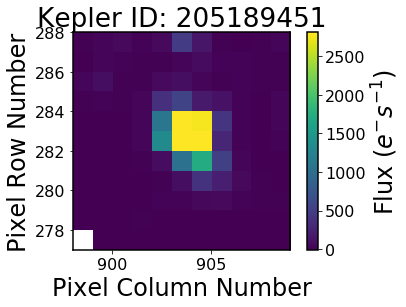

In [7]:
tpf.plot(frame=1697,interpolation='nearest')

### Set up for psf photometry

In [8]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [9]:
scene = SceneModel(prfs=[prf])

In [10]:
prior = UniformPrior(lb=[100., 902., 280., 0.],
                     ub=[50000., 906., 285., 1000.])

In [11]:
prior.mean

array([25050. ,   904. ,   282.5,   500. ])

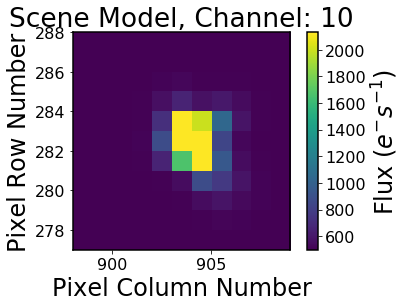

In [12]:
scene.plot(*prior.mean,interpolation='nearest')

In [13]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [16]:
results = phot.fit(tpf.flux)

  0%|          | 0/1993 [00:00<?, ?it/s]/Users/acody/miniconda3/envs/astroconda/lib/python3.5/site-packages/autograd-1.2-py3.5.egg/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/acody/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/acody/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/acody/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
 94%|█████████▍| 1869/1993 [00:40<00:02, 46.63it/s]/Users/acody/miniconda3/envs/astroconda/lib/python3.5/site-packages/autograd-1.2-py3.5.egg/autograd/tracer.py:48: RuntimeWarning: divid

In [17]:
flux = results[:, 0]
xc = results[:, 1]
yc = results[:, 2]
bkg = results[:, 3]

In [18]:
flux.max()

36984.39522389176

### Make some plots of the results

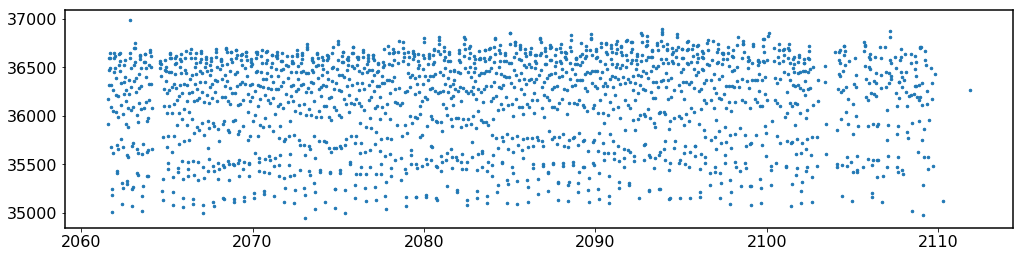

In [19]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux, 'o', markersize=2.5)

#### Check out the fitted centroids

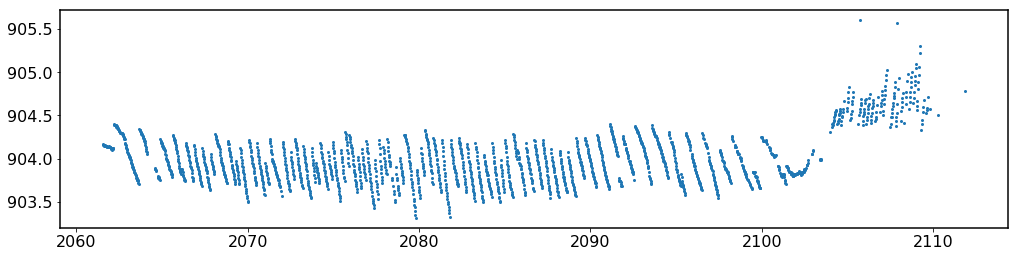

In [20]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, xc, 'o', markersize=2)

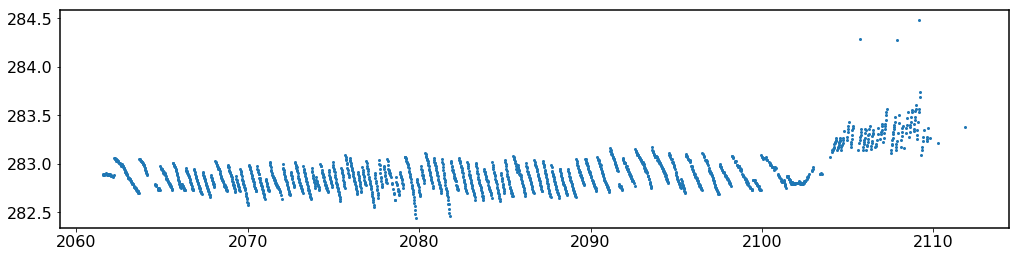

In [21]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, yc, 'o', markersize=2)

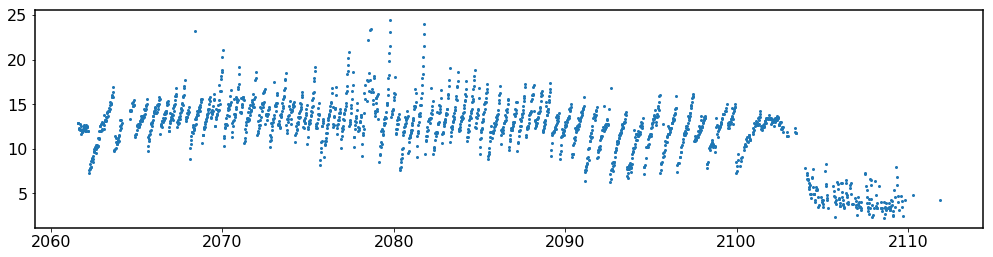

In [22]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time,bkg,'o',markersize=2)

### Now create an aperture photometry light curve for comparison

In [23]:
lc = tpf.to_lightcurve(aperture_mask='pipeline')

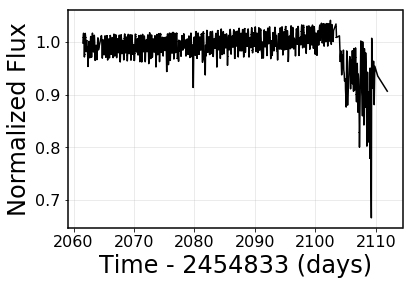

In [24]:
lc.plot()

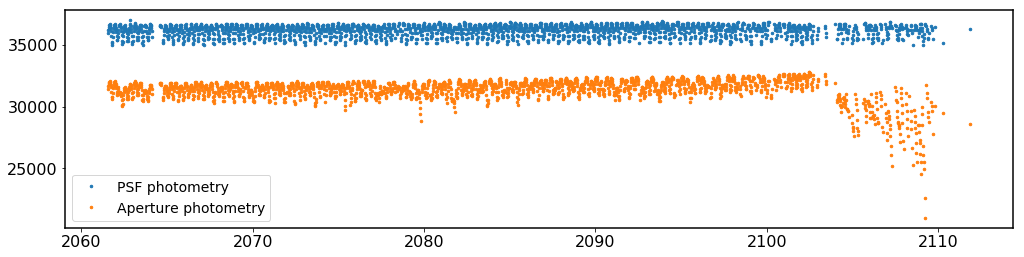

In [25]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux, 'o', markersize=2.5, label='PSF photometry')
plt.plot(tpf.time, lc.flux, 'o', markersize=2.5, label='Aperture photometry')
plt.legend()

### Zoom in on the light curve to see the variability

(2070, 2080)

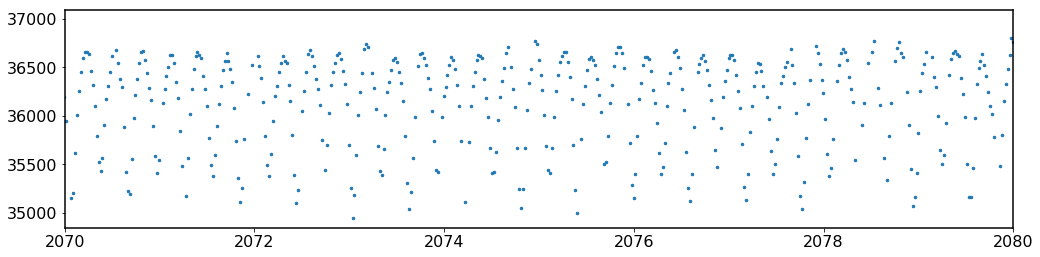

In [26]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux, 'o', markersize=2.5)
plt.xlim(2070,2080)

### Create a lightkurve object so that we can easily fold it

In [28]:
from lightkurve import KeplerLightCurve

In [29]:
lc_psf=KeplerLightCurve(time=tpf.time, flux=flux, flux_err=lc.flux_err)

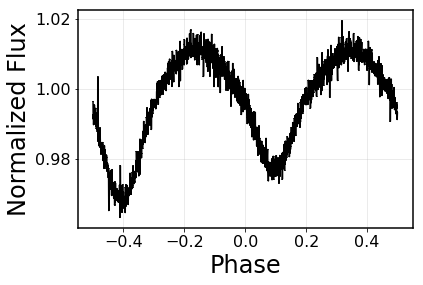

In [30]:
lc_psf.fold(period=0.59152,phase=0.0).plot()